In [1]:
!pip3 install pandas numpy matplotlib seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Đọc dữ liệu đã làm sạch
df = pd.read_csv("sample/bds_hn_data_cleaned.csv")
print(df.shape)
df.head()


(3709, 9)


,published_date,location,home_type,price,area,bedroom,wc,legal_status,furniture
0,07/10/2025,"Gia Lâm, Hà Nội",căn hộ chung cư,4.72,75.0,3.0,2.0,có sổ đỏ/sổ hồng,Đầy đủ
1,07/10/2025,"Đông Anh, Hà Nội",đất,4.28,72.0,3.0,3.0,không có - Thiếu,Không có - Thiếu
2,07/10/2025,"Đan Phượng, Hà Nội","nhà biệt thự, liền kề",38.30,288.0,3.0,3.0,không có - Thiếu,Không có - Thiếu
3,07/10/2025,"Gia Lâm, Hà Nội",căn hộ chung cư,2.75,43.0,1.0,3.0,có sổ đỏ/sổ hồng,Không có - Thiếu
4,07/10/2025,"Đống Đa, Hà Nội",nhà riêng,3.85,18.0,2.0,1.0,có sổ đỏ/sổ hồng,Không có - Thiếu


In [3]:
#Tạo log(target) + rút gọn ngày đăng -> tháng (giữ tinh thần “thuộc tính gốc” nhưng giảm độ phân mảnh)
df['log_price'] = np.log(df['price'])

def to_month_key(x):
    try:
        d,m,y = str(x).split('/')
        return f"{y}-{int(m):02d}"
    except:
        return str(x)

df['published_month'] = df['published_date'].apply(to_month_key)


In [4]:
# Xác định feature set (số & hạng mục) + Target Encoding

numeric_cols = ['area', 'bedroom', 'wc']
categorical_cols = ['location', 'home_type', 'legal_status', 'furniture', 'published_month']

df = df.dropna(subset=numeric_cols + categorical_cols + ['log_price']).copy()

# Target encoding: mean(log_price) theo từng category, fallback bằng global mean
global_mean = float(df['log_price'].mean())
te_maps = {col: df.groupby(col)['log_price'].mean().to_dict() for col in categorical_cols}
te_means = {col: global_mean for col in categorical_cols}

# Ma trận đặc trưng: số (chuẩn hóa) + hạng mục (target-encoded 1D)
X_num = df[numeric_cols].values
y = df['log_price'].values

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

X_cat_te = np.column_stack([df[col].map(te_maps[col]).fillna(te_means[col]).values
                            for col in categorical_cols])

X = np.hstack([X_num_scaled, X_cat_te])
X.shape


(3709, 8)

In [5]:
# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape


((2967, 8), (742, 8))

In [6]:
# Thuật toán Linear Regression bằng Gradient Descent
class LinearRegressionGD:
    def __init__(self, learning_rate=0.05, n_iterations=3000, tol=1e-8):
        self.lr = learning_rate
        self.n_iterations = n_iterations
        self.tol = tol
        self.weights = None
        self.bias = None
        self.cost_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0
        prev = np.inf
        for _ in range(self.n_iterations):
            y_pred = X.dot(self.weights) + self.bias
            err = y_pred - y
            dw = (1/n_samples) * X.T.dot(err)
            db = (1/n_samples) * err.sum()
            self.weights -= self.lr * dw
            self.bias    -= self.lr * db

            cost = (err**2).mean()  # MSE
            self.cost_history.append(cost)
            if abs(prev - cost) < self.tol:
                break
            prev = cost
        return self

    def predict(self, X):
        return X.dot(self.weights) + self.bias


In [7]:
#Huấn luyện & đánh giá (log-space & price-space)
model = LinearRegressionGD(learning_rate=0.05, n_iterations=3000)
model.fit(X_train, y_train)

# Dự đoán log(price)
y_pred_log = model.predict(X_test)

# Chuyển về price
y_test_price = np.exp(y_test)
y_pred_price = np.exp(y_pred_log)

mse_log  = mean_squared_error(y_test, y_pred_log)
r2_log   = r2_score(y_test, y_pred_log)
mse_price = mean_squared_error(y_test_price, y_pred_price)
r2_price  = r2_score(y_test_price, y_pred_price)

print(f"MSE (log_price): {mse_log:.4f}")
print(f"R²  (log_price): {r2_log:.4f}")
print(f"MSE (price): {mse_price:,.0f}")
print(f"R²  (price): {r2_price:.4f}")


MSE (log_price): 0.2758
R²  (log_price): 0.6288
MSE (price): 124
R²  (price): 0.5254


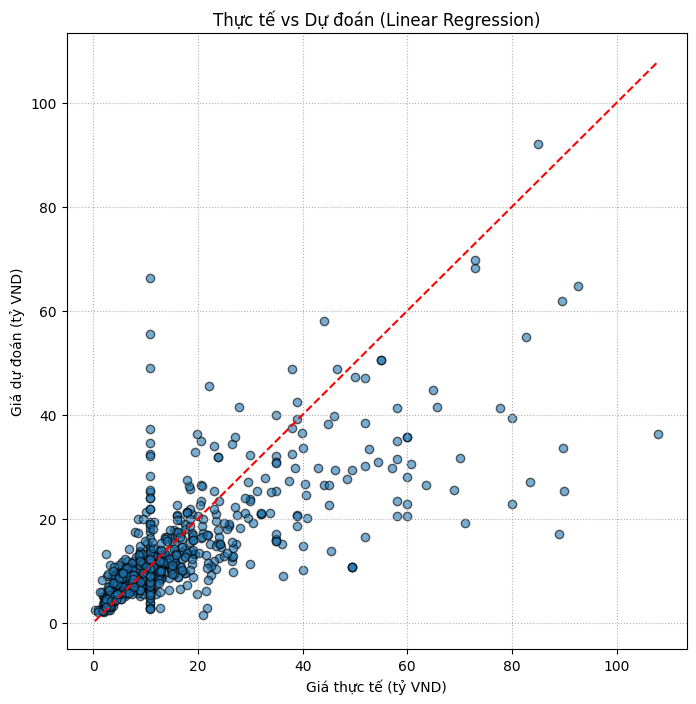

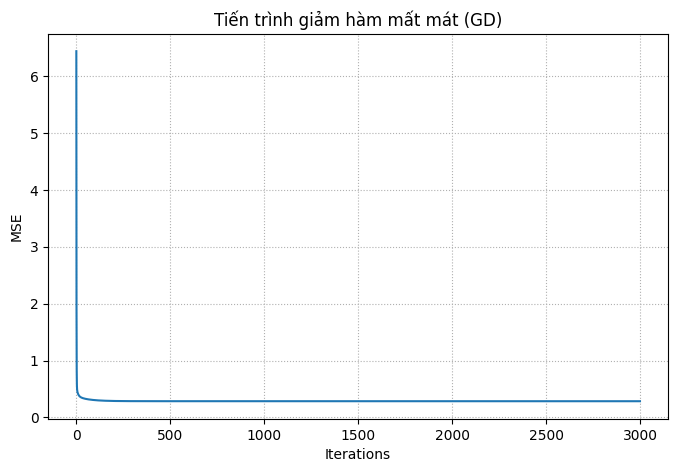

In [8]:
# Trực quan: thực tế vs dự đoán & đường hội tụ

# Thực tế vs dự đoán (price-space)
plt.figure(figsize=(8,8))
plt.scatter(y_test_price, y_pred_price, alpha=0.6, edgecolors='k')
lo, hi = min(y_test_price.min(), y_pred_price.min()), max(y_test_price.max(), y_pred_price.max())
plt.plot([lo, hi], [lo, hi], 'r--')
plt.xlabel("Giá thực tế (tỷ VND)")
plt.ylabel("Giá dự đoán (tỷ VND)")
plt.title("Thực tế vs Dự đoán (Linear Regression)")
plt.grid(True, linestyle=':')
plt.show()

# Gradient Descent convergence
plt.figure(figsize=(8,5))
plt.plot(model.cost_history)
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Tiến trình giảm hàm mất mát (GD)")
plt.grid(True, linestyle=':')
plt.show()


In [9]:
# Lưu artifacts để chạy app (weights, bias, scaler, mapping, order)

import json, os, numpy as np

ART_DIR = "house_price_app"
os.makedirs(ART_DIR, exist_ok=True)

# Trọng số, bias
np.save(os.path.join(ART_DIR, "weights.npy"), model.weights)
np.save(os.path.join(ART_DIR, "bias.npy"),   np.array([model.bias]))

# Scaler cho biến số
scaler_params = {
    "numeric_cols": numeric_cols,
    "mean": scaler.mean_.tolist(),
    "scale": scaler.scale_.tolist(),
}
with open(os.path.join(ART_DIR, "scaler.json"), "w", encoding="utf-8") as f:
    json.dump(scaler_params, f, ensure_ascii=False, indent=2)

# Target-encoding maps
with open(os.path.join(ART_DIR, "te_maps.json"), "w", encoding="utf-8") as f:
    json.dump({k: {str(kk): float(vv) for kk, vv in v.items()} for k, v in te_maps.items()},
              f, ensure_ascii=False, indent=2)
with open(os.path.join(ART_DIR, "te_means.json"), "w", encoding="utf-8") as f:
    json.dump({k: float(v) for k, v in te_means.items()}, f, ensure_ascii=False, indent=2)

# Thứ tự đặc trưng cho vector hóa: số (chuẩn hóa) trước, TE sau
with open(os.path.join(ART_DIR, "feature_order.json"), "w", encoding="utf-8") as f:
    json.dump({"feature_order": numeric_cols + categorical_cols}, f, ensure_ascii=False, indent=2)

# Choices UI (để render dropdown)
ui_choices = {col: sorted(map(str, df[col].dropna().unique().tolist())) for col in categorical_cols}
with open(os.path.join(ART_DIR, "ui_choices.json"), "w", encoding="utf-8") as f:
    json.dump(ui_choices, f, ensure_ascii=False, indent=2)
